I’ve just found an interesting resource for mapping triangles: https://scicomp.stackexchange.com/questions/25327/finding-shape-functions-for-a-triangle-in-3d-coordinate-space

The key idea is to use Lagrange shape functions on the 2D reference triangle, called $\Phi_i(\xi, \eta)$ and that these can be used to perform a mapping between a 2D triangle and a 3D triangle.

First of all, let’s plot these shape functions.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
phi1 = lambda x, y: 1 - x - y
phi2 = lambda x, y:x
phi3 = lambda x, y:y

In [5]:
X, Y = np.meshgrid(np.linspace(0, 1, num=150),
                   np.linspace(0, 1, num=151))

In [6]:
eval_shape_func = lambda phi: phi(X.ravel(), Y.ravel()).reshape(X.shape)

In [48]:
def plot_triangle(ax, triangle_points):
    pts = np.append(triangle_points, triangle_points[0].reshape(1, -1), axis=0)
    ax.plot(pts[:, 0], pts[:, 1])

In [49]:
ref_triangle = np.array([[0, 0.],
                        [1, 0.],
                        [0, 1.]])

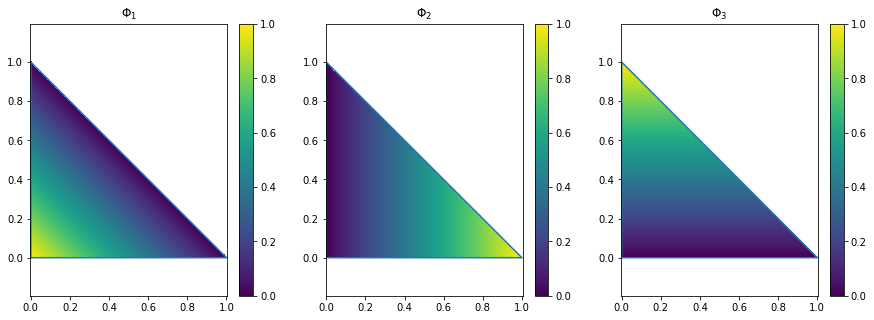

In [52]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

for ind, (ax, phi) in enumerate(zip(axes, [phi1, phi2, phi3])):
    m = ax.pcolormesh(X, Y, np.where((X <= 1 - Y), eval_shape_func(phi), np.nan))
    plt.colorbar(m, ax=ax)
    ax.axis('equal')
    plot_triangle(ax, ref_triangle)
    ax.set_title(f'$\Phi_{ind+1}$')

As you may have noticed from the above plots, each shape function has the very nice property that it is **exactly 1** at one corner of the reference triangle and zero at **both** other vertices. This is useful because it allows us to define a transformation from the local coordinates $(\xi, \eta)$ to other coordinates inside a triangle.

Let’s first do this in 2D. We denote the points of the triangle to which we want to map by $X_i, i=1..3$.

Then, a map can be written:

$$
(x, y) = \sum_{i=1}^3 \Phi_i(\eta, \xi) X_i
$$

Let’s try this out using our already existing points and map to anothe triangle, chosen to be much smaller.

In [53]:
small_triangle = np.array([[0.5, 0.5],
                           [1., 0.5],
                           [0.5, 1.]])

In [54]:
def map_to(xi, eta, new_triangle_points):
    return sum(phi(xi, eta) * p for phi, p in zip([phi1, phi2, phi3], new_triangle_points))

In [55]:
map_to(0, 0, small_triangle)

array([0.5, 0.5])

We can even create a vectorized function that allows us to evaluate several points at once.

In [56]:
def map_to_vectorized(xi, eta, new_triangle_points):
    return sum(phi(xi, eta) * p.reshape(-1, 1) for phi, p in zip([phi1, phi2, phi3], new_triangle_points))

In [57]:
map_to_vectorized(X.ravel(), Y.ravel(), small_triangle)

array([[0.5       , 0.5033557 , 0.50671141, ..., 0.99328859, 0.9966443 ,
        1.        ],
       [0.5       , 0.5       , 0.5       , ..., 1.        , 1.        ,
        1.        ]])

Let’s see where these points land.

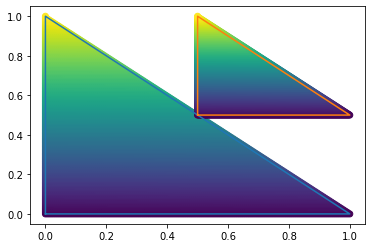

In [66]:
X_filt = np.where((X <= 1 - Y), X, np.nan).ravel()
Y_filt = np.where((X <= 1 - Y), Y, np.nan).ravel(), 

fig, ax = plt.subplots()
plot_triangle(ax, ref_triangle)
plot_triangle(ax, small_triangle)
ax.scatter(X_filt, Y_filt, c=np.arange(X_filt.size))
ax.scatter(*map_to_vectorized(X_filt, 
                              Y_filt, 
                              small_triangle), c=np.arange(X_filt.size))

Nice, here we see that we have managed to map identical points to identical locations. What happens if we permute the points of the small triangle?

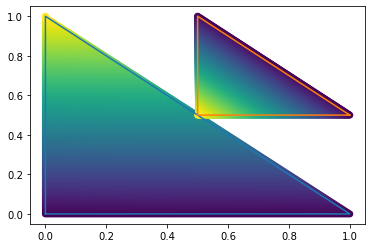

In [67]:
small_triangle2 =  np.array([[1., 0.5],
                           [0.5, 1.],
                            [0.5, 0.5]])


fig, ax = plt.subplots()
plot_triangle(ax, ref_triangle)
plot_triangle(ax, small_triangle2)
ax.scatter(X_filt, Y_filt, c=np.arange(X_filt.size))
ax.scatter(*map_to_vectorized(X_filt, 
                              Y_filt, 
                              small_triangle2), c=np.arange(X_filt.size))

We see that the corners have been exchanged by the mapping, since the corresponding vertices have been exchanged.